In [1]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import numpy as np
from tqdm import trange
import seaborn as sns

from matplotlib import pyplot as plt

Create the dataset

In [2]:
class OneDDataset(torch.utils.data.Dataset):
    def __init__(self, N=100, fn=np.sin, split='train') -> None:
        super().__init__()
        if split == 'train':
            np.random.seed(1001)
        elif split == 'val':
            np.random.seed(2001)
        else:
            np.random.seed(3001)
        x = np.concatenate([-1.5 + np.random.rand(N//2), 0.5 + np.random.rand(N - N//2)])[:,None]
        y = fn(((x+3)/2)**2)

        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,:])

class UniformDataset(torch.utils.data.Dataset):
    def __init__(self, N=500) -> None:
        super().__init__()

        x = -3 + 6*np.random.rand(N)[:,None]
        y = x
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,:])


In [43]:
# DNN mapping 2d input to 1d distribution parameter 
model = torch.nn.Sequential(
    torch.nn.Linear(1, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1)
)

# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Normal(loc=theta, scale=0.05)

mean_loss=-2.054957: 100%|██████████| 100/100 [00:01<00:00, 86.42it/s]


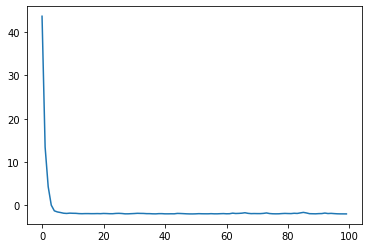

In [44]:
dataset = OneDDataset()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

losses = []
t = trange(100)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        dist = dist_constructor(outputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss
        
        optimizer.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

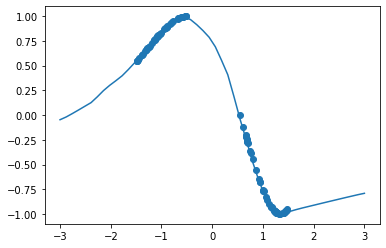

In [45]:
X = np.linspace(-3.,3.,50)
xx_tensor = torch.from_numpy(X).view(-1,1).float()
yhat = model(xx_tensor)
yhat = yhat[:,0].detach().cpu().numpy()

plt.plot(X,yhat)
plt.scatter(dataset.X[:,0], dataset.Y)

In [46]:
from scod.utils import gaussianWassersteinDist

In [47]:
Sig1 = torch.randn(4,4)
Sig1 = Sig1 @ Sig1.t()

Sig2 = torch.randn(4,4)
Sig2 = Sig2 @ Sig2.t()

Sig2eigdecomp = torch.linalg.eigh(Sig2)

# print(Sig2eigdecomp.eigenvectors @ (Sig2eigdecomp.eigenvalues[None,:] * Sig2eigdecomp.eigenvectors).t())
# print(Sig2)

print(Sig1, Sig2)

gaussianWassersteinDist(Sig1, Sig2)

tensor([[ 3.4034, -1.2328, -1.9458, -1.8668],
        [-1.2328,  0.9483,  0.6064, -0.0188],
        [-1.9458,  0.6064, 15.1995, -1.0708],
        [-1.8668, -0.0188, -1.0708,  2.4305]]) tensor([[ 3.9369, -2.9948,  0.9546,  0.3900],
        [-2.9948,  4.1245,  0.2337,  0.5545],
        [ 0.9546,  0.2337,  5.0941, -2.2402],
        [ 0.3900,  0.5545, -2.2402,  3.2206]])


tensor(7.2667)

In [48]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'prior_type': 'per_parameter',
})

Weight space dimension: 8.513e+03


In [49]:
unc_model.process_dataset(dataset)

computing basis
using T = 304


  0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
gp_reg_unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'prior_type': 'per_weight',
})

Weight space dimension: 8.513e+03


In [68]:
def GP_kernel(inputs):
    sq_dist = torch.norm( (inputs[:,None,:] - inputs[None,:,:]), dim=-1 )**2
    length_scale = 0.2
    kernel = torch.exp(- sq_dist / length_scale)
    return kernel

uniform_dataset = UniformDataset()
gp_reg_unc_model.log_prior_scale.data *= 0
loss_curve, min_eigs = gp_reg_unc_model.optimize_prior_scale_by_GP_kernel(uniform_dataset, GP_kernel, num_epochs=30, batch_size=10)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

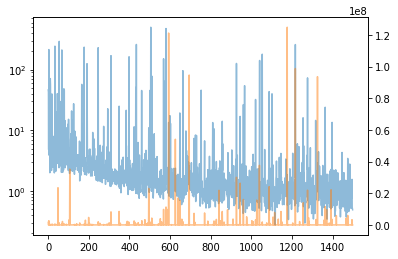

In [69]:
fig, ax = plt.subplots()
ax.semilogy(loss_curve, alpha=0.5)
ax2 = ax.twinx()
ax2.plot(1./np.array(min_eigs), color='C1', alpha=0.5)

In [70]:
gp_reg_unc_model.process_dataset(dataset)

computing basis
using T = 304


  0%|          | 0/100 [00:00<?, ?it/s]

In [71]:
gp_reg_unc_model_2 = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'prior_type': 'per_weight',
})

Weight space dimension: 8.513e+03


In [72]:
def GP_kernel_2(inputs):
    sq_dist = ( (inputs[:,None,0] - inputs[None,:,0])**2 )
    length_scale = 2.0
    kernel = torch.exp(- sq_dist / length_scale)
    return kernel

uniform_dataset = UniformDataset()
gp_reg_unc_model_2.log_prior_scale.data *= 0
loss_curve, min_eigs = gp_reg_unc_model_2.optimize_prior_scale_by_GP_kernel(uniform_dataset, GP_kernel_2, num_epochs=30, batch_size=10)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

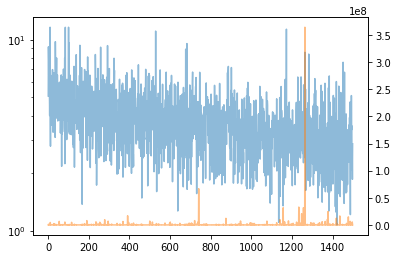

In [73]:
fig, ax = plt.subplots()
ax.semilogy(loss_curve, alpha=0.5)
ax2 = ax.twinx()
ax2.plot(1./np.array(min_eigs), color='C1', alpha=0.5)

In [74]:
gp_reg_unc_model_2.process_dataset(dataset)

computing basis
using T = 304


  0%|          | 0/100 [00:00<?, ?it/s]

In [75]:
settings = [
    {   
        'name': 'Unit Prior',
        'model': unc_model,
        'prior_scales': 0*unc_model.log_prior_scale,
    },
    {   
        'name': r'GP ($\lambda = 0.2$)',
        'model': gp_reg_unc_model,
        'prior_scales': None,
    },
    {   
        'name': r'GP ($\lambda = 1.0$)',
        'model': gp_reg_unc_model_2,
        'prior_scales': None,
    }
]

In [76]:
results = []
for setting in settings:
    scod_model = setting['model']
    old_prior_scales = scod_model.log_prior_scale.data + 0.
    if setting['prior_scales'] is not None:
        scod_model.log_prior_scale.data = setting['prior_scales']
    
    dists, _ = scod_model(xx_tensor)
    prior_dists, _ = scod_model(xx_tensor, use_prior=True)

    scod_model.log_prior_scale.data = old_prior_scales
    vars = np.array( [torch.sqrt(dist.variance).sum().detach().cpu() for dist in dists] )
    prior_vars = np.array( [torch.sqrt(dist.variance).sum().detach().cpu() for dist in prior_dists] )
    result = {
        'name': setting['name'],
        'vars': vars.reshape(X.shape),
        'prior_vars': prior_vars.reshape(X.shape)
    }
    results.append(result)

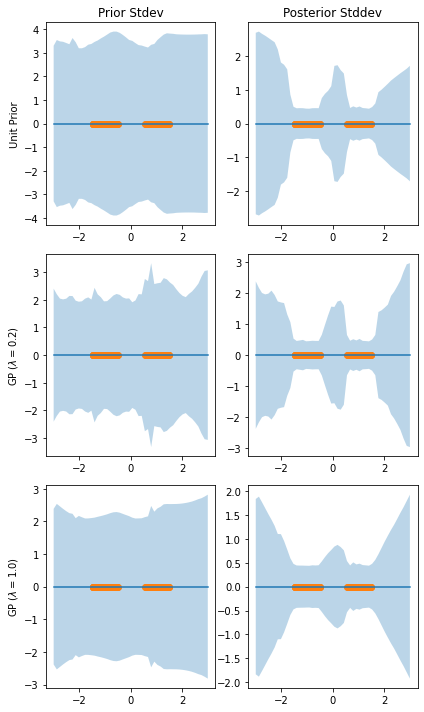

In [77]:
fig, axes = plt.subplots(len(results), 2, figsize=[6,10])
for i, result in enumerate(results):
    std = np.sqrt(result['prior_vars'])
    axes[i,0].fill_between(X, 0*yhat + 1.92*std, 0*yhat - 1.92*std, alpha=0.3)
    axes[i,0].plot(X, 0*yhat)
    axes[i,0].scatter(dataset.X[:,0], 0*dataset.Y)
    std = np.sqrt(result['vars'])
    axes[i,1].fill_between(X, 0*yhat + 1.92*std, 0*yhat - 1.92*std, alpha=0.3)
    axes[i,1].plot(X, 0*yhat)
    axes[i,1].scatter(dataset.X[:,0], 0*dataset.Y)
    
    axes[i,0].set_ylabel(result['name'])

axes[0,0].set_title('Prior Stdev')
axes[0,1].set_title('Posterior Stddev')

plt.tight_layout()

Text(0.5, 1.0, 'Distribution of per-weight prior variances')

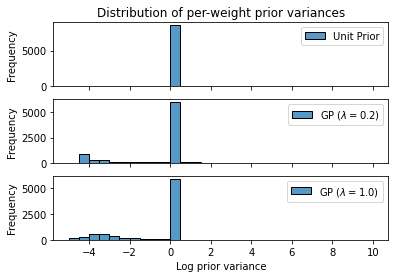

In [67]:
fig, axes = plt.subplots(len(settings),1, sharex=True)

for ax, setting in zip(axes, settings):
    log_prior_scale = setting['model'].log_prior_scale.detach().cpu()
    if setting['prior_scales'] is not None:
        log_prior_scale = setting['prior_scales'].detach().cpu()
    sns.histplot(setting['model']._broadcast_to_n_weights(log_prior_scale), ax=ax, label=setting['name'], binrange=[-5,10], binwidth=0.5)
    ax.legend()
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Log prior variance')

axes[0].set_title('Distribution of per-weight prior variances')
